In [1]:
import random
import os
import time
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import minimize
import warnings
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
import torch.nn as nn
from torch.nn import init, Module, Parameter  # PyTorch syntax for optimization problems
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from sklearn.datasets import make_swiss_roll
from scipy.stats import wishart
from sklearn.utils import shuffle as util_shuffle
import ot
from sklearn.decomposition import PCA


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
#Creating ring dataset from scratch and cheating as well 
n_points = 2500

In [10]:
linspace = np.linspace(0, 2 * np.pi, n_points, endpoint=False)

In [11]:
x1 = np.cos(linspace)
y1 = np.sin(linspace)

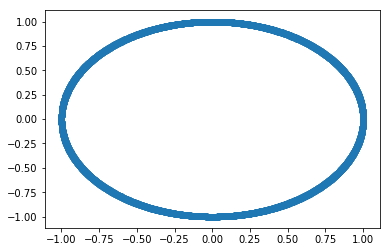

In [12]:
plt.scatter(x1,y1)

In [19]:
X1 = np.stack((x1,y1), axis=1)

In [23]:
X11 = X1.reshape(25,100,2)

In [30]:
x2 = .75*np.cos(linspace)
y2 = .75*np.sin(linspace)
X2 = np.stack((x2,y2), axis=1)
X22 = X2.reshape(25,100,2)

In [31]:
x3 = .5*np.cos(linspace)
y3 = .5*np.sin(linspace)
X3 = np.stack((x3,y3), axis=1)
X33 = X3.reshape(25,100,2)

In [32]:
x4 = .25*np.cos(linspace)
y4 = .25*np.sin(linspace)
X4 = np.stack((x4,y4), axis=1)
X44 = X4.reshape(25,100,2)

In [38]:
X = np.concatenate([X11,X22,X33,X44], axis=0)

In [4]:
##### Next 2 cells to create the toy datasets in Convex Flows paper. 

Log2PI = float(np.log(2 * np.pi))

def log_normal(x, mean, log_var, eps=0.00001):
    z = - 0.5 * Log2PI
    return - (x - mean) ** 2 / (2. * torch.exp(log_var) + eps) - log_var / 2. + z


def log_standard_normal(x):
    z = - 0.5 * Log2PI
    return - x ** 2 / 2 + z


In [5]:
class ToyDataset(Dataset):
    data = dict()
    data_names = []

    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        cls.data[cls.__name__] = cls
        cls.data_names.append(cls.__name__)

    def __init__(self, n=50000):
        self.data = self.sample(n)

    def sample(self, batch_size):
        raise NotImplementedError

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


class SwissRoll(ToyDataset):
    """
    Swiss roll distribution sampler.
    noise control the amount of noise injected to make a thicker swiss roll
    """
    def sample(self, batch_size, noise=0.5):
        return torch.from_numpy(
            make_swiss_roll(batch_size, noise)[0][:, [0, 2]].astype('float64') / 5.)


# taken from https://github.com/nicola-decao/BNAF/blob/master/data/generate2d.py
class TwoSpirals(ToyDataset):
    def sample(self, batch_size):
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        return torch.from_numpy(x).float()


class EightGaussian(ToyDataset):
    def sample(self, batch_size, return_idx=False):
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        indices = []
        for i in range(batch_size):
            point = np.random.randn(2) * 0.5
            idx = np.random.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
            indices.append(idx)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        if return_idx:
            return torch.from_numpy(dataset), torch.from_numpy(np.array(indices))
        else:
            return torch.from_numpy(dataset)


class Rings(ToyDataset):
    def sample(self, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, we set endpoint=False
        linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
        linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
        linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
        linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

        circ4_x = np.cos(linspace4)
        circ4_y = np.sin(linspace4)
        circ3_x = np.cos(linspace4) * 0.75
        circ3_y = np.sin(linspace3) * 0.75
        circ2_x = np.cos(linspace2) * 0.5
        circ2_y = np.sin(linspace2) * 0.5
        circ1_x = np.cos(linspace1) * 0.25
        circ1_y = np.sin(linspace1) * 0.25

        X = np.vstack([
            np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
            np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
        ]).T * 3.0
        X = util_shuffle(X)

        # Add noise
      #  X = X + np.random.normal(scale=0.08, size=X.shape)

  #screwing with shapes to work out in my case batch size is divisible by 100
        X = torch.from_numpy(X.astype("float32"))
       # return X.reshape(500, 100, 2)
        return X


class MAFMoon(ToyDataset):
    def sample(self, batch_size):
        x = torch.randn(batch_size, 2)
        x[:,0] += x[:,1] ** 2
        x[:,0] /= 2
        x[:,0] -= 2
        return x


def gaussian_sampler(mean, log_var):
    sigma = torch.exp(0.5*log_var)
    return torch.randn(*mean.shape) * sigma + mean


class OneDMixtureOfGaussians(ToyDataset):
    """
    Mixture of Gaussians:
        x ~ p(x; pi) = pi N(m1, var) + (1-pi) N(m2, var)
        with pi ~ uniform(0,1)
    """

    m1 = 2 * torch.ones(1)
    m2 = -2 * torch.ones(1)
    log_var = -1 * torch.ones(1)

    def sample(self, batch_size):
        m1 = torch.ones(batch_size, 1) * self.m1
        m2 = torch.ones(batch_size, 1) * self.m2
        log_var = torch.ones(batch_size, 1) * self.log_var
        s1 = gaussian_sampler(m1, log_var)
        s2 = gaussian_sampler(m2, log_var)
        pi = torch.rand(batch_size, 1)
        mask = torch.le(torch.rand(batch_size, 1), pi).float()
        return torch.cat([mask * s1 + (1-mask) * s2, pi], 1)

    def logp(self, x, pi):
        log_pi1 = np.log(pi)
        log_pi2 = np.log(1-pi)
        lp1 = log_normal(x, self.m1, self.log_var)
        lp2 = log_normal(x, self.m2, self.log_var)
        return torch.logsumexp(torch.cat([lp1+log_pi1, lp2+log_pi2], 1), 1)

    def plot_logp(self):
        import matplotlib.pyplot as plt
        xx = torch.linspace(-5, 5, 1000).unsqueeze(1)
        for pi in np.linspace(0.1, 0.9, 11):
            p = torch.exp(self.logp(xx, pi)).data.numpy()
            plt.plot(xx, p)


class Gaussian(ToyDataset):

    def __init__(self, n, dim=2, m=None, C=None):
        if m is None:
            m = np.random.randn(dim)
        if C is None:
            C = wishart.rvs(dim+1, np.identity(dim), 1)
        self.m = m
        self.C = C
        super(Gaussian, self).__init__(n)

    def sample(self, batch_size):
        return torch.from_numpy(np.random.multivariate_normal(self.m, self.C, batch_size)).float()

    @property
    def entropy(self):
        return 0.5 * np.linalg.slogdet(2*np.pi*np.exp(1)*self.C)[1]



In [66]:
# x = torch.rand(2, 100, 1)
# y = torch.rand(2, 100, 1)
# Define a Sinkhorn (~Wasserstein) loss between sampled measures
loss = SamplesLoss(loss='sinkhorn',debias=False, p=1, blur=1e-3, scaling=0.999, backend='auto').to(device)
#The EMD loss as is explained in the github issues

In [41]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 128),
            nn.ELU(inplace=True),
            nn.Linear(128, 64),
            nn.ELU(inplace=True),
            nn.Linear(64, 16),
            nn.ELU(inplace=True),
            nn.Linear(16, 6),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x


In [43]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

      #  return cost, pi, C
        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1


In [44]:
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)

In [45]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
           
        return x

    def __len__(self):
        return len(self.data)
    

In [50]:
dataset = MyDataset(torch.from_numpy(X))
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [15]:
# dataset = 'Rings' 
# ToyData = ToyDataset.data[dataset]
# loader = DataLoader(ToyData(50000), batch_size = 20, shuffle = True)

In [46]:
# def optimizer_to(optim, device):
#     for param in optim.state.values():
#         # Not sure there are any global tensors in the state dict
#         if isinstance(param, torch.Tensor):
#             param.data = param.data.to(device)
#             if param._grad is not None:
#                 param._grad.data = param._grad.data.to(device)
#         elif isinstance(param, dict):
#             for subparam in param.values():
#                 if isinstance(subparam, torch.Tensor):
#                     subparam.data = subparam.data.to(device)
#                     if subparam._grad is not None:
#                         subparam._grad.data = subparam._grad.data.to(device)

In [47]:
encoder = DeepSet(2, 36)
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=0.001)
encoder.to(device)
# checkpoint = torch.load('autoencoder_encoder_unstructured.pt')
# encoder.load_state_dict(checkpoint['model_state_dict'])
#encoder.to(device)

# torch.cuda.empty_cache()
# optimizer_encoder.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizer_to(optimizer_encoder,device)

# loss = checkpoint['loss']

# # # model.load_state_dict(torch.load('deepset_dist_flat1.pkl'))
# encoder.train()

# model.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=128, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=16, out_features=6, bias=True)
  )
)

In [48]:
class MLPDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, set_size):
        super().__init__()
        self.output_channels = output_channels
        self.input_channels = input_channels
      
        self.set_size = set_size
        self.model = nn.Sequential(
            nn.Linear(input_channels, 16),
            nn.ELU(inplace=True),
            nn.Linear(16, 32),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(32, 128),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(128, 256),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
#             nn.Linear(36, 100),
#             nn.ELU(inplace=True),
#             nn.Linear(100, 256),
#             nn.Dropout(p=.5),
#             nn.ELU(inplace=True),
            nn.Linear(256, output_channels*set_size)
        
        )
        


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        x = x.view(x.size(0), self.set_size, self.output_channels)
        
        return x

In [49]:
decoder = MLPDecoder(6,2,100)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001, weight_decay=.001)
decoder.to(device)
# checkpoint = torch.load('autoencoder_decoder_unstructured.pt')
# decoder.load_state_dict(checkpoint['model_state_dict'])
# # decoder.to(device)

# torch.cuda.empty_cache()
# optimizer_decoder.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizer_to(optimizer_decoder,device)
# loss = checkpoint['loss']

# decoder.train()


MLPDecoder(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=32, out_features=128, bias=True)
    (6): ELU(alpha=1.0, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): ELU(alpha=1.0, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=256, out_features=200, bias=True)
  )
)

In [41]:
# def calculate_loss(batch, n_data, a, y, y_a, y_translate):
#     loss = [0,0,0]
#     y_norm = torch.pdist(y)
#     n_data_pairwise_1 = []
#     n_data_pairwise_2 = []
#     for i in range(len(batch)):
#         for j in range(i+1,len(batch)):
#             n_data_pairwise_1.append(n_data[i])
#             n_data_pairwise_2.append(n_data[j])
#     n_data_pairwise_1 = torch.stack(n_data_pairwise_1)
#     n_data_pairwise_2 = torch.stack(n_data_pairwise_2)
#     w_norm = sinkhorn(n_data_pairwise_2, n_data_pairwise_1)
#     y_a_norm = torch.pdist(y_a)
#     y_translate_norm = torch.pdist(y_translate)
#     loss[0] = (y_norm - w_norm).abs().sum()
#     loss[1] = ((y_a_norm - a * y_norm) ** 2).sum()
#     loss[2] = ((y_translate_norm - y_norm) ** 2).sum()
#     loss = sum(loss)
#     del w_norm
#     return loss

In [67]:
num_epochs = 300
running_loss = []
for t in range(num_epochs):
    
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch.to(device), requires_grad=True)
        a = torch.rand(1).to(device)
        b = torch.rand(2).to(device)
       
    
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
#         w = torch.empty(n_data.shape)
#         noise = Variable(nn.init.normal_(w, mean=0.0, std=.001), requires_grad=True).to(device)
        y = encoder(n_data)
#         y1 = encoder(n_data + noise)
        y_a = encoder(a*n_data)
        y_translate = encoder(n_data + b)
        
        
        z = decoder(y)
        
 
        
        loss_encoder = 0
        loss_decoder = 0
#         loss_encoder = calculate_loss(batch, n_data, a, y, y_a, y_translate)
#         loss_encoder = loss_encoder/(len(batch)*(len(batch)-1)/2)
        
        
       
        for i in range(len(batch)):
            loss_decoder += 10*(loss(z[i], n_data[i])**2)
            loss_decoder = loss_decoder/len(batch)
            
            for j in range(i+1,len(batch)):
                
                y_ij = torch.norm(y[i]-y[j], p=2)
                w_ij = sinkhorn(n_data[i],n_data[j]) 
                
                ya_ij = torch.norm(y_a[i]-y_a[j], p=2)
                y_translate_ij = torch.norm(y_translate[i]-y_translate[j], p=2)
                
                diff_translate_ij = torch.norm(y_translate[i]-y[j], p=2)**2
                
    
                loss_encoder += torch.norm(y_ij-w_ij, p=2) + (ya_ij-a*y_ij)**2 + (y_translate_ij- y_ij)**2
                
                del w_ij
        #TODO FIX THE LAST TERMS WITH PAIRWISE DISTANCES (SEE PYTORCH CODE)
        
        
        loss_encoder = loss_encoder/(len(batch)*(len(batch)-1)/2)
    
        
        loss_batch = loss_encoder + loss_decoder
       
        loss_batch.backward(retain_graph=False)
       
        optimizer_decoder.step()
        optimizer_encoder.step()
        
        torch.cuda.empty_cache() 
    
        
    running_loss.append(loss_batch.item())
    print(loss_encoder.item(), loss_decoder.item())
   
   

0.19465480744838715 0.19199234247207642
0.2358497828245163 0.5935378074645996
0.15968932211399078 0.9661762714385986
0.18187105655670166 0.22710619866847992
0.22042827308177948 0.9244383573532104
0.340267151594162 2.5403239727020264
0.3556671738624573 5.558732032775879
0.17644457519054413 0.35634368658065796
0.12620818614959717 1.2885546684265137
0.4765518605709076 2.3498992919921875
0.3987867832183838 1.4699406623840332
0.21550874412059784 0.42882484197616577
0.15669146180152893 4.795144081115723
0.21704846620559692 1.1251497268676758
0.3407750725746155 0.7415241003036499
0.32295656204223633 1.919022798538208
0.37847256660461426 0.5787813663482666
0.4339038133621216 1.8774337768554688
0.34819430112838745 0.6372545957565308
0.36711081862449646 0.6392532587051392
0.32603543996810913 1.107908844947815
0.29921579360961914 1.842969536781311
0.24379877746105194 1.790820598602295
0.2467627227306366 2.761446475982666
0.3228123188018799 3.1108412742614746
0.20252668857574463 0.9339599609375
0.

0.18976876139640808 0.10150466859340668
0.355571985244751 0.060711733996868134
0.43528300523757935 0.744275689125061
0.18565580248832703 0.05875710770487785
0.24163591861724854 1.01668119430542
0.4618622660636902 0.5835433006286621
0.43611544370651245 0.2668633460998535
0.44652554392814636 0.8146049976348877
0.24484191834926605 0.1921578347682953
0.21970593929290771 0.20189550518989563
0.12876316905021667 0.21596823632717133
0.4721710681915283 0.2460651695728302
0.23301178216934204 0.4804774522781372
0.30621588230133057 0.7889043688774109
0.41299304366111755 0.6085582375526428
0.1690666675567627 0.12667207419872284
0.3470315933227539 0.5383227467536926
0.48484325408935547 0.16211405396461487
0.25737905502319336 0.8018718361854553
0.3071708679199219 0.27244675159454346
0.16723036766052246 0.22672784328460693
0.15981876850128174 0.21003508567810059
0.24768275022506714 0.15523965656757355
0.2851368188858032 0.5687544941902161
0.21143439412117004 0.04581218212842941
0.20988522469997406 0.2

KeyboardInterrupt: 

In [68]:
len(running_loss)

283

In [78]:
#decoder loss is now changed to EMD loss
torch.save({
    
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer_encoder.state_dict(),
            'loss': loss
            
            }, 'autoencoder_encoder_unstructured_trywithemd.pt')

torch.save({
    
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer_decoder.state_dict(),
            'loss': loss
            
            }, 'autoencoder_decoder_unstructured_emd.pt')

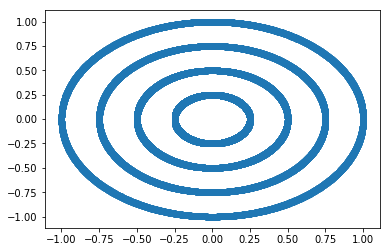

In [54]:
plt.scatter(X.reshape(10000,2)[:,0], X.reshape(10000,2)[:,1])

In [70]:
pca = PCA(2)

In [ ]:
Y = torch.from_numpy(X)

In [71]:
y = encoder(Y.to(device).float())

In [72]:
pca.fit(y.detach().cpu().numpy())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [73]:
y_pca = pca.transform(y.detach().cpu().numpy())

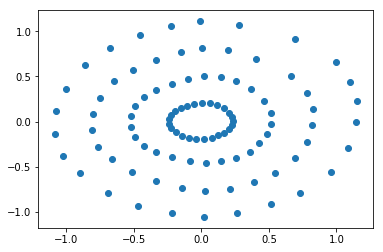

In [74]:
plt.scatter(y_pca[:,0],y_pca[:,1])

In [76]:
z = decoder(encoder(Y.to(device).float()))

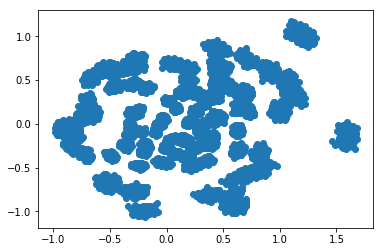

In [77]:
plt.scatter(z.detach().cpu().reshape(10000,2)[:,0], z.detach().cpu().reshape(10000,2)[:,1])